# A genetic analysis of tomato leaflet morphology using high-resolution pseudo-landmarks

_________

The following is a `jupyter notebook` ([Kluyver et al. 2016](https://ebooks.iospress.nl/doi/10.3233/978-1-61499-649-1-87)) tutorial written using the `python` coding language. Text written in `markdown cells` is used to explain code presented and executed in `coding cells`. This tutorial assumes a working knowledge of `python` and the ability to use `jupyter notebooks`.  

If you are new to `python` or do not know how to use `jupyter notebooks`, we recommend that you familiarize yourself with them through a tutorial. For the context of plant biology and leaf shape presented here, we recommend `Plants&Python` ([VanBuren et al., 2022](https://doi.org/10.1093/plcell/koac187)), accessible using this [link](https://plantsandpython.github.io/PlantsAndPython). There you will find instructions for downloading and installing [Anaconda](https://docs.anaconda.com/anaconda/install/) and how to get going with `jupyter notebooks` and `python`.

### Import modules

We first import modules which contain functions and other code necessary to perform the analysis in this `jupyter notebook`.

Below, we provide references for some of the modules used in this notebook:  

- `pandas`, [McKinney, 2010](http://conference.scipy.org.s3.amazonaws.com/proceedings/scipy2010/pdfs/mckinney.pdf)
- `numpy`, [Harris et al., 2020](https://www.nature.com/articles/s41586-020-2649-2)
- `matplotlib`, [Hunter, 2007](https://www.computer.org/csdl/magazine/cs/2007/03/c3090/13rRUwbJD0A)
- `scikit-learn`, [Pedregosa et al., 2011](https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf?ref=https:/)
- `scipy`, [Virtanen et al., 2020](https://www.nature.com/articles/s41592-019-0686-2)
- `seaborn`, [Waskom, 2021](https://joss.theoj.org/papers/10.21105/joss.03021.pdf)
- `statsmodels`, [Seabold & Perktold, 2010](https://pdfs.semanticscholar.org/3a27/6417e5350e29cb6bf04ea5a4785601d5a215.pdf)

In [1]:
import pandas as pd # for reading in csv files and using dataframes
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import numpy as np # for working with arrays and other functions
import matplotlib.pyplot as plt # for plotting and visualization
import matplotlib as mpl # for plotting and visualization
from sklearn.decomposition import PCA # for principal component analysis
from scipy.interpolate import interp1d # for interpolating points
import math # for mathematical operations
from scipy.spatial import ConvexHull # for convex hull
from scipy.spatial import procrustes # for Procrustes analysis
import seaborn as sns # for plotting in seaborn
from shapely.geometry import Point # for determining if points lie within a polygon
from shapely.geometry.polygon import Polygon # for determining if points lie within a polygon
from scipy import stats # for calculation of spearman r
import statsmodels.stats.multitest as sm # for multiple test adjustment
import matplotlib.cm as cm # for retrieving color maps
from matplotlib.colors import Normalize # for normalizing color maps"

### Define functions

The following functions define useful operations used in the analysis.

In [2]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated x and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean


### Rationale and data sources

To demonstrate how high-resolution pseudo-landmarks that define a continuous curve can be individually analyzed for their genetic basis, we use previously collected leaflet data from the *Solanum pennellii* introgression lines (ILs). These 76 lines contain small genetic introgressions from a *S. pennellii* accession from the Atacama Desert in a domesticated tomato background (*S. lycopersicum*, var. M82). Together, the introgressions tile the genome. Overlaps between the introgressions define 112 genetic bins. If a phenotypic difference between lines harboring a specific *S. pennellii* introgression is found relative to those that do not, the genetic basis of such a difference maps back to the precisely mapped bin in the respective IL(s) ([Chitwood et al., 2013](https://doi.org/10.1105/tpc.113.112391)).

Each IL was planted with a replication of 10 in a randomized block design in Davis, California in 2010 ([Chitwood et al., 2013](https://doi.org/10.1105/tpc.113.112391)). For each replicate, 5 leaves were sampled, in which the terminal and most proximal left and right lateral leaflets (15 leaflets total per replicate) were flattened under glass and photographed with a copy stand. Coordinate outlines of each leaflet have been saved as numpy arrays as `.npy` files in the folder `Tomato_field` from [Wang, Willey, and Chitwood, 2024](https://doi.org/10.6084/m9.figshare.25435936.v1). **In order to perform this analysis, you must download the folder `Tomato_field` from [Wang, Willey, and Chitwood, 2024](https://doi.org/10.6084/m9.figshare.25435936.v1) and place the folder in the current working directory.** Leaflet `.npy` files are named by field position and leaflet type. The field position code file (`IL_field_codes.csv`) was merged to the bin code file (derived from Supplemental Dataset 2 from [Chitwood et al., 2013](https://doi.org/10.1105/tpc.113.112391), `tpc112391_Supplemental+Dataset+2.csv`) by IL identity so that we could determine the genetic identity of each leaflet file.

In [3]:
# read in field codes
field_codes = pd.read_csv("./IL_field_codes.csv")

# read in bin codes
bin_codes = pd.read_csv("./tpc112391_Supplemental+Dataset+2.csv")

# save column "bin" for column names for transposed bin_codes
col_names = bin_codes["bin"]

# transpose bin_codes
bin_codes = bin_codes.T.set_axis(col_names, axis=1)

# drop the first row of bin codes (remove bin names from the transposition)
bin_codes = bin_codes.iloc[1:]

# rename the row index to "genotype" for merging 
bin_codes.index.name = 'genotype'

# make the row index of genotype a column for merging
bin_codes.reset_index(inplace=True)

# merge the plant field IDs with bin codes by IL 
plant_IL_bin = field_codes.merge(bin_codes, "right")

# head the data to check
plant_IL_bin.head()

,plant,genotype,d-1A,d-1B,d-1C,d-1D,d-1E,d-1F,d-1G,d-1H,...,d-12A,d-12B,d-12C,d-12D,d-12E,d-12F,d-12G,d-12H,d-12I,d-12J
0,G30,IL_1.1.2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B33,IL_1.1.2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,S14,IL_1.1.2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,F23,IL_1.1.2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,D34,IL_1.1.2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Calculating pseudo-landmarks

The `.npy` files containing leaflet coordinates are contained in two different folders. The file names present in each directory were saved to access each file.

In [4]:
# set data directories to analyze
data_dirs = ["./Tomato_field/F1/","./Tomato_field/F2/"]

lft_files = [] # a list to store leaflet files to analyze

for d in data_dirs: # for each data directory
    
    data_dir = d # set current directory

    file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

    #file_names.remove('.DS_Store') # remove .DS_Store file

    file_names.sort() # sort the list of file names
    
    for n in range(len(file_names)): # for each file name in this directory
        lft_files.append(data_dir+file_names[n]) # save the path to list lft_files

Before pseudo-landmarks are calculated, different parameters are provided. An arbitrarily high number of points (in this case, `10,000`) is defined to first place this number of equidistant points around the original contour, in which the number of points is originally arbitrary and they are not equidistantly placed. A list of problem files to skip is provided. Most importantly, the final resolution `res`, the final number of pseudo-landmarks, is defined. The resolution is roughly the number of equidistant points on each side of the leaflet. In this case, the resolution is `50`, which yields `99` (or `res*2-1`) final pseudo-landmarks, in which the index of the tip of the leaf is `res-1` and the index of the base is `0`. The final number of pseudo-landmarks is not simply twice the resolution because the tip point is placed twice for each side, and one point is removed to avoid redundancy. The original field position of the plant the leaflet was collected from and whether the leaf was a terminal (`T`), left (`L`), or right (`R`) distal lateral leaflet is extracted from the file name. The field position is cross-referenced against the field code file to determine the introgression line (IL) identity of the plant. The file path, IL, and leaflet identities for the file are all stored to list and afterwards combined together into a `pandas` dataframe. The dataframe is used to index the pseudo-landmark data, either by leaflet or IL identity.

Leaves are oriented and the base and tip indices found using principal component analysis (PCA). The leaves already have intrinsic orientation: they are all roughly pointed upward. The maximum and minimum `y` coordinate values in the outline's original orientation are stored for reference. Next, a PCA is used to orient the leaflet along its length by calculating its longest axis (`PC1`) and its width along the orthogonal axis (`PC2`). The maximum and minimum `PC1` values are checked against the estimated tip and base points from the original orientation: the closest tip and base point from the original orientation to the maximum and minimum `PC1` values is used to determined their identity. Using the high-resolution interpolation of the contour, the indices of the tip and base are calculated and the base index set to `0`. The resolution value `res` is then used to place the desired number of equidistant pseudo-landmarks on each side of the leaf, taking care to remove the duplicate point at the tip. Finally, leaflets are rotated so that the tip points upward for aesthetic purposes.

In [5]:
######################
### SET PARAMETERS ###
######################

# the number of equidistant points to create
# an initial high resolution outline of the leaflet
high_res_pts = 10000

# a list of problem files to skip
problem_files = ["./Tomato_field/F1/F_i1o_l3.npy",
                 "./Tomato_field/F2/F_n33_r1.npy",
                 "./Tomato_field/F2/F_n33_r2.npy",
                 "./Tomato_field/F2/F_n33_r3.npy",
                 "./Tomato_field/F2/F_n33_r4.npy",
                 "./Tomato_field/F2/F_n33_r5.npy"
                ]

# the ultimate number of equidistant points on each side of the leaflet
# (res-1 for the index of the tip, 0 for the index of the base)
# the leaflet will have res*2-1 pseudo-landmarks
#################
#################
res = 50 ########
#################
#################

# get information for each file
file_paths = [] # to store file path info
IL_list = [] # to store IL identity
term_lat_list = [] # store terminal or lateral leaflet identity

# an array to store pseudo-landmarks
# note it is the number of leaflet files minue problem files
data_arr = np.zeros((len(lft_files)-len(problem_files),(res*2)-1,2))

counter = 0 

for i in range(len(lft_files)): # for each leaflet
    
    #############################################
    ### READ IN DATA AND RETRIEVE INFORMATION ###
    #############################################

    name = lft_files[i] # get current file name
    
    # skip problem files
    if name in problem_files:
        continue

    if i%500==0: # print every 500th i
        print(i)
    
    # get the leaflet identity
    lft = name[-6]

    # if terminal leaflet, set lft to "T"
    if lft=="t":
        lft="T"
    # else if a left lateral leaflet, set lft to "L"
    elif (lft=="l")|(lft=="1") : 
        lft="L"
    # otherwise, set lateral leaflet to "R"
    else:
        lft="R"

    # to find the field position code
    # first find the last "_" index position
    last_us_ind = name.rfind("_") 

    # find the next "_" index position after that
    next_us_ind = name.rfind("_",0,last_us_ind)

    # isolate the field code and convert to upper case
    field_code = name[next_us_ind+1:last_us_ind].upper()

    # get IL identity by masking
    IL = field_codes["genotype"][field_codes["plant"]==field_code].item()

    # store file path, leaflet and IL identities
    file_paths.append(name)
    IL_list.append(IL)
    term_lat_list.append(lft)
    
    ################################################
    ### ORIENT LEAF AND FIND BASE AND TIP POINTS ###
    ################################################
    
    # load in leaflet coordinates
    lf = np.load(name) 

    # leaflets are already oriented
    # retrieve the max and min y values to mark tip and base, respectively
    tip_ind = lf.argmax(axis=0)
    base_ind = lf.argmin(axis=0)

    # perform PCA to find longest axis
    pca = PCA(n_components=2)
    pca = pca.fit_transform(lf)

    # retrieve indices by PCA
    pca_tip_ind = pca.argmax(axis=0)
    pca_base_ind = pca.argmin(axis=0)

    # confirm that PCA indices correspond to original tip/base orientation
    if (np.abs(lf[tip_ind[1],1]-pca[tip_ind[1],0]))<(np.abs(lf[base_ind[1],1]-pca[tip_ind[1],0])):
        # if the difference between two tips less than previous base and new tip
        # everything is good and set tip and base points
        tip_pt = pca[pca_tip_ind[0],:]
        base_pt = pca[pca_base_ind[0],:]

    else:
        # is above is not true, then reverse the tip/base assignments
        tip_pt = pca[pca_base_ind[0],:]
        base_pt = pca[pca_tip_ind[0],:]
    
    ################################################
    ### INTERPOLATE HIGH RES NUMBER OF LANDMARKS ###
    ################################################

    # convert the leaflet to high resolution number of landmarks
    # using high_res_pt value
    # need to convert arrays of pixel int to floats first
    high_res_x, high_res_y = interpolation(pca[:,0], 
                                           pca[:,1], high_res_pts)
    
    ###############################
    ### FIND BASE AND TIP INDEX ###
    ###############################

    base_dists = [] # store distance of each high res point to base
    tip_dists = [] # store distance of each high res point to tip

    for pt in range(len(high_res_x)): # for each of the high resolution points

        # euclidean distance of the current point from the base and tip landmark
        ed_base = euclid_dist(base_pt[0], base_pt[1], high_res_x[pt], high_res_y[pt])
        ed_tip = euclid_dist(tip_pt[0], tip_pt[1], high_res_x[pt], high_res_y[pt])

        # store distance of current point from base/tip
        base_dists.append(ed_base)
        tip_dists.append(ed_tip)

    # get index of base and tip points
    base_ind = np.argmin(base_dists)
    tip_ind = np.argmin(tip_dists)
    
    ################################
    ### RESET BASE INDEX TO ZERO ###
    ################################

    # reset base index position to zero
    high_res_x = np.concatenate((high_res_x[base_ind:],high_res_x[:base_ind]))
    high_res_y = np.concatenate((high_res_y[base_ind:],high_res_y[:base_ind]))

    # recalculate indices with new indexing
    tip_ind = tip_ind-base_ind # note: negative index if tip_ind<base_ind
    base_ind = base_ind-base_ind

    # create single array for leaflet coordinates
    lf_contour = np.column_stack((high_res_x, high_res_y))
    
    ##############################################################
    ### INTERPOLATE EACH SIDE WITH DESIRED NUMBER OF LANDMARKS ###
    ##############################################################

    # interpolate at desired resolution the left and right sides of the leaflet
    left_inter_x, left_inter_y = interpolation(lf_contour[base_ind:tip_ind+1,0],lf_contour[base_ind:tip_ind+1,1],res)
    right_inter_x, right_inter_y = interpolation(lf_contour[tip_ind:,0],lf_contour[tip_ind:,1],res)

    # the start of the right side and end of the left side
    # both contain the tip landmark
    # delete the last point on the left side
    left_inter_x = np.delete(left_inter_x, -1)
    left_inter_y = np.delete(left_inter_y, -1)

    # BASE OF LEAF IS INDEX 0
    # TIP INDEX IS RES-1 IF BOTH LEFT & RIGHT POINTS
    # TOTAL PSEUDOLANDMARKS IS 2*RES-1
    lf_pts_left = np.column_stack((left_inter_x, left_inter_y))
    lf_pts_right = np.column_stack((right_inter_x, right_inter_y))
    lf_pts = np.row_stack((lf_pts_left, lf_pts_right))
    
    ##########################################################
    ### ROTATE LEAVES UPWARD AND SCALE SIZE TO CENTIMETERS ###
    ##########################################################

    tip_point = lf_pts[res-1,:] # get tip point
    base_point = lf_pts[0,:] # get base point

    # calculate angle between tip. base, and an arbitrary reference
    ang = angle_between(tip_point, base_point, (base_point[0]+1,base_point[1]) )

    # rotate points upwards
    rot_x, rot_y = rotate_points(lf_pts[:,0], lf_pts[:,1], ang) 
    rot_pts = np.column_stack((rot_x, rot_y))
    
    # store the leaflet into data_arr
    data_arr[counter,:,:] = rot_pts
    
    counter+=1
    
#########################################
### COMBINE METADATA INTO A DATAFRAME ###
#########################################
    
# create a pandas dataframe
mdata = pd.DataFrame({
    "file":file_paths,
    "IL":IL_list,
    "leaflet":term_lat_list,
})

# create masked dataframes for terminal and lateral leaflets
# note: mirror left and right due to image reflection
term_df = mdata[mdata["leaflet"]=="T"]
left_df = mdata[mdata["leaflet"]=="L"]
right_df = mdata[mdata["leaflet"]=="R"]

# similarly mask arrays with leaflet shapes
term_arr = data_arr[term_df.index,:,:]
left_arr = data_arr[left_df.index,:,:]
right_arr = data_arr[right_df.index,:,:]
    

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000


### Generalized Procrustes analysis (GPA)

Procrustean alignment was carried out separately for the terminal and distal left and right lateral leaflets. To superimpose contours from each group by minimizing the overall distance between pseudo-landmark values through the functions of translation, scaling, rotation, and reflection, a generalized Procrustes analysis (GPA) is used ([Gower, 1975](https://link.springer.com/article/10.1007/BF02291478)). A function was defined to calculate a GPA mean. To calculate the GPA mean, an arbitrary leaflet is first chosen and all other leaflets are aligned to it using Procrustean superimposition. A mean from the aligned shapes is calculated, which is used as the reference shape for alignment in the next iteration. The algorithm stops when the Procrustes distance between means calculated between two successive iterations falls below an arbitrarily low value. All leaflets are then aligned to the final GPA mean shape. The Procrustean superimposition of each leaflet type was visualized by plotting each leaflet with high transparency together with its respective mean.

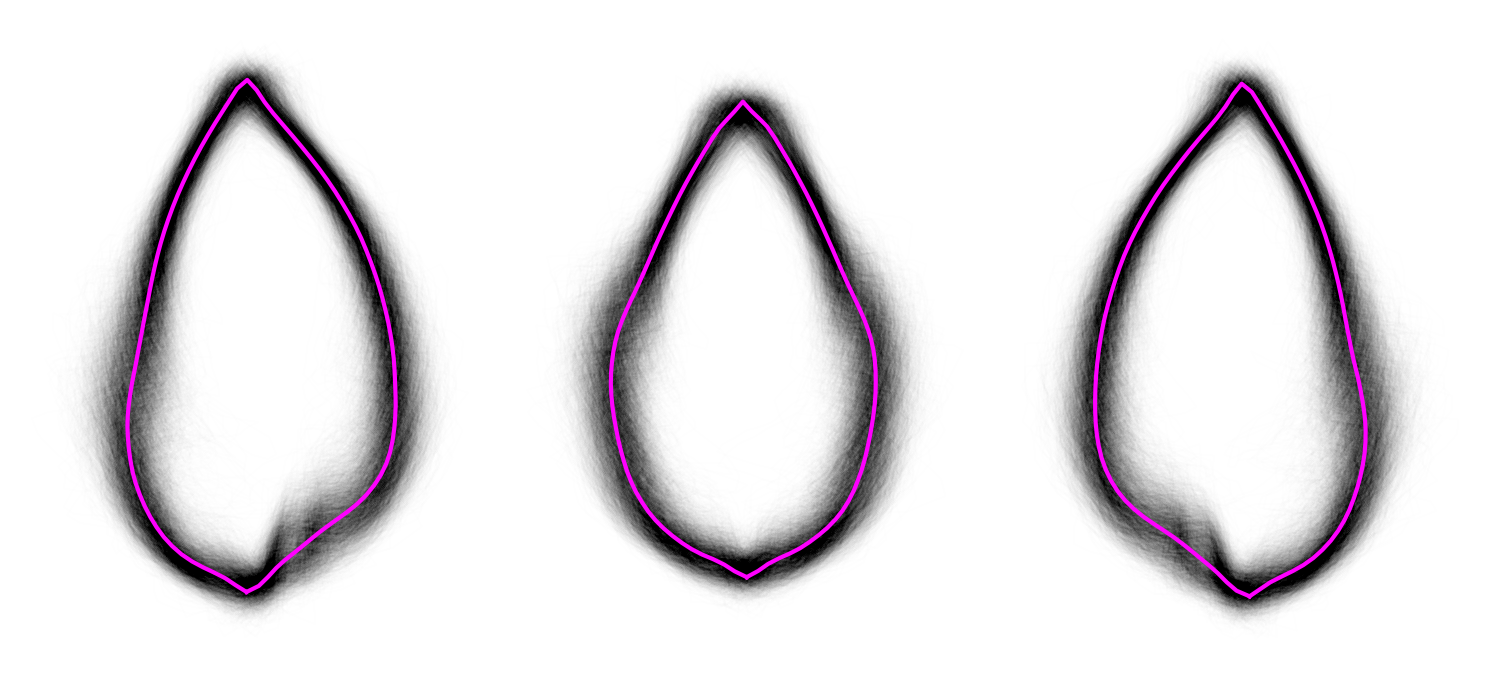

In [6]:
landmark_num = (res*2)-1 # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

###########################
### CALCULATE GPA MEANS ###
###########################

term_mean_shape = gpa_mean(term_arr, landmark_num, dim_num)
left_mean_shape = gpa_mean(left_arr, landmark_num, dim_num)
right_mean_shape = gpa_mean(right_arr, landmark_num, dim_num)

##################################
### ALIGN LEAFLETS TO GPA MEAN ###
##################################

# array to store terminal Procrustes aligned shapes
proc_term_arr = np.zeros(np.shape(term_arr)) 

for i in range(len(term_arr)):
    s1, s2, distance = procrustes(term_mean_shape, term_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaflet
    proc_term_arr[i] = s2 # store procrustes adjusted shape to array
    
# array to store left Procrustes aligned shapes
proc_left_arr = np.zeros(np.shape(left_arr)) 

for i in range(len(left_arr)):
    s1, s2, distance = procrustes(left_mean_shape, left_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaflet
    proc_left_arr[i] = s2 # store procrustes adjusted shape to array
    
# array to store right Procrustes aligned shapes
proc_right_arr = np.zeros(np.shape(right_arr)) 

for i in range(len(right_arr)):
    s1, s2, distance = procrustes(right_mean_shape, right_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaflet
    proc_right_arr[i] = s2 # store procrustes adjusted shape to array
    
##########################
### VISUALIZE LEAFLETS ###
##########################

plt.figure(figsize=(15,10))

# left leaflet
for i in range(len(proc_left_arr)):
    plt.subplot(1,3,1)
    plt.plot(-proc_left_arr[i,:,0], proc_left_arr[i,:,1], c="k", alpha=0.005)

plt.subplot(1,3,1)
plt.plot(-left_mean_shape[:,0], left_mean_shape[:,1], c="magenta", lw=3)
plt.gca().set_aspect("equal")
plt.axis("off")

# terminal leaflet
for i in range(len(proc_term_arr)):
    plt.subplot(1,3,2)
    plt.plot(proc_term_arr[i,:,0], proc_term_arr[i,:,1], c="k", alpha=0.005)

plt.subplot(1,3,2)
plt.plot(term_mean_shape[:,0], term_mean_shape[:,1], c="magenta", lw=3)
plt.gca().set_aspect("equal")
plt.axis("off")

# right leaflet
for i in range(len(proc_right_arr)):
    plt.subplot(1,3,3)
    plt.plot(proc_right_arr[i,:,0], proc_right_arr[i,:,1], c="k", alpha=0.005)

plt.subplot(1,3,3)
plt.plot(right_mean_shape[:,0], right_mean_shape[:,1], c="magenta", lw=3)
plt.gca().set_aspect("equal")
plt.axis("off")

plt.tight_layout()


### Genetic analysis (terminal leaflet)

***The analysis below is for the terminal leaflet only. See after this for analyses of the left and right lateral leaflets.***

To dissect the genetic architecture underlying tomato leaflet shape to discrete locations in the leaflet, the distance of each pseudo-landmark to its respective mean was calculated. To do so, functions from the python module `shapely` provided directionality, by determining whether a point lies outside or inside the mean shape. Only ILs were used, as ultimately the correlation of the Eulcidean distance of each pseudo-landmark to the mean with the presence or absence of a specific introgression defining a bin was used to determine a genetic effect. 

In [83]:
####################################################################
### CALCULATE DISTANCES FROM MEAN FOR EACH POINT FOR EACH SAMPLE ###
####################################################################

# convert the mean shape into a shapely polygon object
shapely_polygon = Polygon(term_mean_shape)

# an array to store the Euclidean distance of each point of each leaflet to the mean leaflet
euclid_term_arr = np.zeros((
    len(term_df[term_df["IL"]!="m82"]), # the first dimension is the number of leaflets, not m82
    np.shape(proc_term_arr)[1] # the second dimension is the number of landmark points
))

term_ILs = [] # a list to store terminal leaflet IL identities

counter = 0

for lf in range(np.shape(proc_term_arr)[0]): # for each leaflet "lf"
    
    if term_df["IL"].iloc[lf]=="m82": # if the current leaflet is m82, continue
        continue
        
    else: # else, proceed with the IL leaflet
        term_ILs.append(term_df["IL"].iloc[lf])
    
    for pt in range(np.shape(proc_term_arr)[1]): # then, for that leaflet, for each point "pt"
        
        x1 = term_mean_shape[pt,0] # x1 is the x value of point pt for the mean shape
        y1 = term_mean_shape[pt,1] # y1 is the y value of point pt for the mean shape
        
        x2 = proc_term_arr[lf,pt,0] # x2 is the x value of leaflet lf of point pt 
        y2 = proc_term_arr[lf,pt,1] # y2 is the y value of leaflet lf of point pt 
        
        shapely_point = Point(x2, y2) # convert point to Shapely point object
        
        d = euclid_dist(x1, y1, x2, y2) # calculate the Euclidean distance d
        
        if shapely_polygon.contains(shapely_point): # if the mean shape contains the point
            d = -d # then the point is inside the mean shape and it should be negative
        else:
            d = d # else the point is outside the mean shape and it should remain positive
        
        euclid_term_arr[counter,pt] = d # store the distance value in the lf, pt position of the euclid_arr
        
    counter+=1

# take a look at the shape/dimensions of the final array
print(np.shape(euclid_term_arr))

(3609, 99)


Using dataframes, the presence or absence of each bin (encoded in binary `1` or `0`) for each IL line was merged with the IL identity of the leaflets analyzed. Spearman's rank correlation was used to correlate bin presence or absence with directional Euclidean distance. Both the p-value associated with Spearan's rho and the distance of the pseudo-landmark to the mean were stored for visualization and further analysis.

In [84]:
###################################################
### CALCULATE PVALS FOR EACH POINT FOR EACH BIN ###
###################################################

IL_bin_df = plant_IL_bin.iloc[:,1:].drop_duplicates() # drop duplicate values of IL_bin_df
IL_bin_df.rename(columns={'genotype':'IL'}, inplace=True) # rename genotype to IL for merging
term_IL_df = pd.DataFrame({"IL":term_ILs}) # convert term_IL list to df and name column IL for merging
term_IL_bin = term_IL_df.merge(IL_bin_df, "left") # merge the term leaflet IL identities to bins

# an array to store the spearman r p vals for each point, for each bin
term_pt_r = np.zeros((
    np.shape(euclid_term_arr)[1], # number of points
    len(term_IL_bin.iloc[:,1:].columns) # number of bins
))

# an array to store the average distances from mean for each point, for each bin
term_pt_d = np.zeros((
    np.shape(euclid_term_arr)[1], # number of points
    len(term_IL_bin.iloc[:,1:].columns) # number of bins
))

for pt in range(np.shape(euclid_term_arr)[1]): # for each point
    
    if pt%10==0: # print every 10th point
        print(pt)
    
    curr_pt = euclid_term_arr[:,pt] # get distances for current point

    for b in range(len(term_IL_bin.iloc[:,1:].columns)): # for each bin
                   
        curr_bins = np.array(term_IL_bin.iloc[:,b+1]) # get the current bin presence values
        mean_dist = np.mean(curr_pt[np.where(curr_bins==1)]) # average euclid dist of points harboring current bin
        term_pt_d[pt,b] = mean_dist # store mean distances of points with current bin identity
        res = stats.spearmanr(curr_pt, curr_bins) # calculate spearman correlation
        term_pt_r[pt,b] = res[1] # store spearman r value to array
                    

0
10
20
30
40
50
60
70
80
90


Resulting p values were multiple test adjusted using the Benjamini-Hochberg (BH) false discovery rate-controlling procedure, their sign converted to the direction of the deviation of the pseudo-landmark from the mean (negative for inside the mean contour and positive for outside), and visualized as negative log-base 10 values. The plot of pseudo-landmark position along the leaflet vs. bin position along the genome shows the dynamic genetic architecture across the leaflet blade continuously.

(0.0, 112.0, 99.0, 0.0)

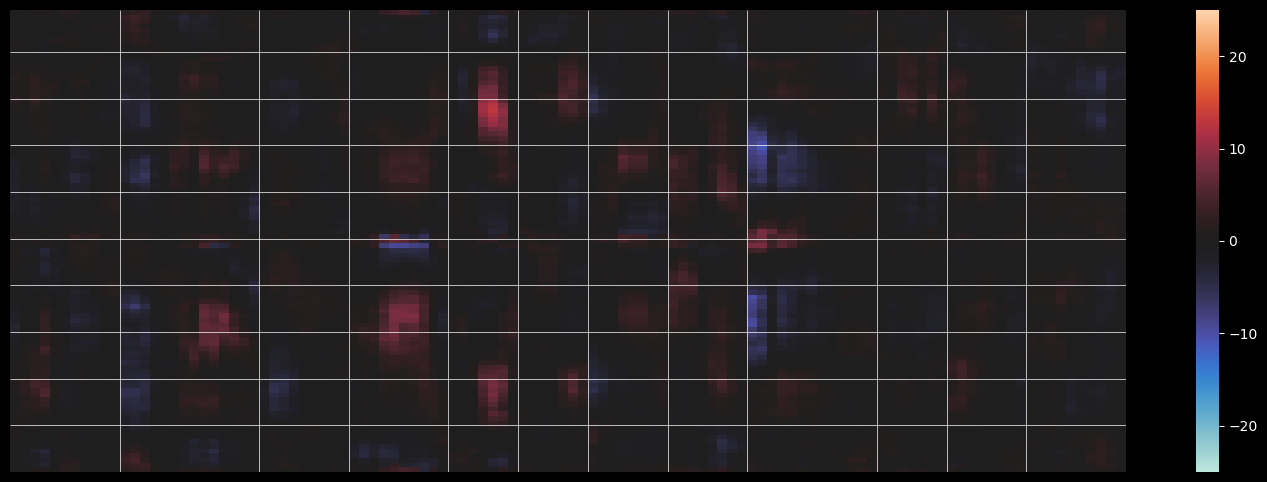

In [85]:
##########################################################
### VISUALIZE QTL FOR EACH PSEUDO-LANDMARK ACROSS BINS ###
##########################################################

# convert p vals to 1D array
term_pt_r_1D = np.reshape(term_pt_r, (np.shape(term_pt_r)[0]*np.shape(term_pt_r)[1]))

# calculate corrected p vals
corr_pvals = sm.multipletests(term_pt_r_1D, method="fdr_bh")[1]

# convert back to 2D array
corr_pvals_2D = np.reshape(corr_pvals, (np.shape(term_pt_r)[0],np.shape(term_pt_r)[1]))

# convert to -log10 p values
# change sign to that of the direction of distance from the mean
neglog10_pvals = -np.log10(corr_pvals_2D)*np.sign(term_pt_d)

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(neglog10_pvals, linewidths=0, ax=ax, cmap="icefire", vmin=-25, vmax=25)
ax.hlines([9,19,29,39,49,59,69,79,89], *ax.get_xlim(), color="white", lw=0.5)
ax.vlines([11,25,34,44,51,58,66,74,87,94,102,112], *ax.get_ylim(), color="white", lw=0.5)
plt.axis("off")

To visualize the genetic effect on shape continuously along the leaflet, we approximated the displacement contriubted by each significant quantitative trait locus (QTL) for each pseudo-landmark. For each QTL with a significant multiple test-adjusted p value, the p value (indicated by color), the displaced distance from the leaflet, and the respective point were stored. The directionality of the displacement from the mean contributed by each significant QTL was visualized as a normal vector inside or outside the mean shape. The start of the normal vector representing the displacement was calculated from the midpoint of neighboring pseudo-landmarks to the end point using the length of the displacement. Only significant displacements were visualized and a diverging color scheme was consistently used in the visualizations to indicate direction and the strength of the p-value.

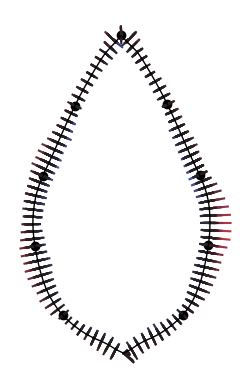

In [86]:
###################################################
### RETREIVE POINT INDICES, DISTANCES, AND PVALS###
###################################################

pts = [] # store the point indices
dists = [] # store the associated distances
pvals = [] # store the associated p values

for pt in range(np.shape(neglog10_pvals)[0]): # for each point
    
    for b in range(np.shape(neglog10_pvals)[1]): # for each bin
        
        curr_pval = neglog10_pvals[pt,b] # get the current p values
        
        if np.abs(curr_pval)>-np.log10(0.05): # only if the p value is <0.05
            pts.append(pt) # store the point identity
            dists.append(term_pt_d[pt,b]) # store the distance
            pvals.append(curr_pval) # store the p values

#################################################
### CALCULATE ENDPOINT OF NORMAL TO MEAN SHAPE###
#################################################

x0_vals = [] # store the mid point x vals
y0_vals = [] # store the mid point y vals
x3_vals = [] # store the end point x vals
y3_vals = [] # store the end point y vals
p_vals = [] # store the p vals

for i in range(len(pts)): # for all the points
    
    if pts[i]>=98: # because of indexing prev and next points, stop the point before
        continue

    D = dists[i] # find the current distance

    x1 = term_mean_shape[(pts[i])-1,0] # get the neighboring point xval before
    x2 = term_mean_shape[(pts[i])+1,0] # get the neighboring point xval after
    y1 = term_mean_shape[(pts[i])-1,1] # get the neighboring point yval before
    y2 = term_mean_shape[(pts[i])+1,1] # get the neighboring point yval after

    x3 = (x1+x2)/2-(( D/(np.sqrt((y1-y2)**2+(x2-x1)**2)))*(y1-y2)) # calculate the end x val point
    y3 = (y1+y2)/2-(( D/(np.sqrt((y1-y2)**2+(x2-x1)**2)))*(x2-x1)) # calculate the end y val point

    x0 = term_mean_shape[pts[i],0] # get the current x val
    y0 = term_mean_shape[pts[i],1] # get the current y val
    
    # store values
    x0_vals.append(x0)
    y0_vals.append(y0)
    x3_vals.append(x3)
    y3_vals.append(y3)
    p_vals.append(pvals[i])
    
#################################################
### VISUALIZE DISPLACEMENTS AROUND THE LEAFLET###
#################################################

cmap = plt.colormaps.get_cmap("icefire") # select color map
norm = Normalize(vmin=-25, vmax=25) # normalize
rgba_values = cmap(norm(p_vals)) # store cmap values for plotting

fig = plt.figure(facecolor="w")

for i in range(len(p_vals)):
    
    xvals = [x0_vals[i], x3_vals[i]]
    yvals = [y0_vals[i], y3_vals[i]]
    
    plt.plot(np.array(xvals), yvals, c=rgba_values[i])
    plt.gca().set_aspect("equal")
    plt.axis("off")

plt.plot(term_mean_shape[:,0], 
         term_mean_shape[:,1], 
         c="k",lw=1)

plt.scatter(term_mean_shape[[9,19,29,39,49,59,69,79,89],0], 
            term_mean_shape[[9,19,29,39,49,59,69,79,89],1], 
            c="k")

### Genetic analysis (left lateral leaflet)

***The analysis below is for the left lateral leaflet only.***

To dissect the genetic architecture underlying tomato leaflet shape to discrete locations in the leaflet, the distance of each pseudo-landmark to its respective mean was calculated. To do so, functions from the python module `shapely` provided directionality, by determining whether a point lies outside or inside the mean shape. Only ILs were used, as ultimately the correlation of the Eulcidean distance of each pseudo-landmark to the mean with the presence or absence of a specific introgression defining a bin was used to determine a genetic effect. 

In [87]:
####################################################################
### CALCULATE DISTANCES FROM MEAN FOR EACH POINT FOR EACH SAMPLE ###
####################################################################

# convert the mean shape into a shapely polygon object
shapely_polygon = Polygon(left_mean_shape)

# an array to store the Euclidean distance of each point of each leaflet to the mean leaflet
euclid_left_arr = np.zeros((
    len(left_df[left_df["IL"]!="m82"]), # the first dimension is the number of leaflets, not m82
    np.shape(proc_left_arr)[1] # the second dimension is the number of landmark points
))

left_ILs = [] # a list to store left leaflet IL identities

counter = 0

for lf in range(np.shape(proc_left_arr)[0]): # for each leaflet "lf"
    
    if left_df["IL"].iloc[lf]=="m82": # if the current leaflet is m82, continue
        continue
        
    else: # else, proceed with the IL leaflet
        left_ILs.append(left_df["IL"].iloc[lf])
    
    for pt in range(np.shape(proc_left_arr)[1]): # then, for that leaflet, for each point "pt"
        
        x1 = left_mean_shape[pt,0] # x1 is the x value of point pt for the mean shape
        y1 = left_mean_shape[pt,1] # y1 is the y value of point pt for the mean shape
        
        x2 = proc_left_arr[lf,pt,0] # x2 is the x value of leaflet lf of point pt 
        y2 = proc_left_arr[lf,pt,1] # y2 is the y value of leaflet lf of point pt 
        
        shapely_point = Point(x2, y2) # convert point to Shapely point object
        
        d = euclid_dist(x1, y1, x2, y2) # calculate the Euclidean distance d
        
        if shapely_polygon.contains(shapely_point): # if the mean shape contains the point
            d = -d # then the point is inside the mean shape and it should be negative
        else:
            d = d # else the point is outside the mean shape and it should remain positive
        
        euclid_left_arr[counter,pt] = d # store the distance value in the lf, pt position of the euclid_arr
        
    counter+=1

# take a look at the shape/dimensions of the final array
print(np.shape(euclid_left_arr))

(3602, 99)


Using dataframes, the presence or absence of each bin (encoded in binary `1` or `0`) for each IL line was merged with the IL identity of the leaflets analyzed. Spearman's rank correlation was used to correlate bin presence or absence with directional Euclidean distance. Both the p-value associated with Spearan's rho and the distance of the pseudo-landmark to the mean were stored for visualization and further analysis.

In [88]:
###################################################
### CALCULATE PVALS FOR EACH POINT FOR EACH BIN ###
###################################################

IL_bin_df = plant_IL_bin.iloc[:,1:].drop_duplicates() # drop duplicate values of IL_bin_df
IL_bin_df.rename(columns={'genotype':'IL'}, inplace=True) # rename genotype to IL for merging
left_IL_df = pd.DataFrame({"IL":left_ILs}) # convert left_IL list to df and name column IL for merging
left_IL_bin = left_IL_df.merge(IL_bin_df, "left") # merge the left leaflet IL identities to bins

# an array to store the spearman r p vals for each point, for each bin
left_pt_r = np.zeros((
    np.shape(euclid_left_arr)[1], # number of points
    len(left_IL_bin.iloc[:,1:].columns) # number of bins
))

# an array to store the average distances from mean for each point, for each bin
left_pt_d = np.zeros((
    np.shape(euclid_left_arr)[1], # number of points
    len(left_IL_bin.iloc[:,1:].columns) # number of bins
))

for pt in range(np.shape(euclid_left_arr)[1]): # for each point
    
    if pt%10==0: # print every 10th point
        print(pt)
    
    curr_pt = euclid_left_arr[:,pt] # get distances for current point

    for b in range(len(left_IL_bin.iloc[:,1:].columns)): # for each bin
                   
        curr_bins = np.array(left_IL_bin.iloc[:,b+1]) # get the current bin presence values
        mean_dist = np.mean(curr_pt[np.where(curr_bins==1)]) # average euclid dist of points harboring current bin
        left_pt_d[pt,b] = mean_dist # store mean distances of points with current bin identity
        res = stats.spearmanr(curr_pt, curr_bins) # calculate spearman correlation
        left_pt_r[pt,b] = res[1] # store spearman r value to array
                    

0
10
20
30
40
50
60
70
80
90


Resulting p values were multiple test adjusted using the Benjamini-Hochberg (BH) false discovery rate-controlling procedure, their sign converted to the direction of the deviation of the pseudo-landmark from the mean (negative for inside the mean contour and positive for outside), and visualized as negative log-base 10 values. The plot of pseudo-landmark position along the leaflet vs. bin position along the genome shows the dynamic genetic architecture across the leaflet blade continuously.

(0.0, 112.0, 99.0, 0.0)

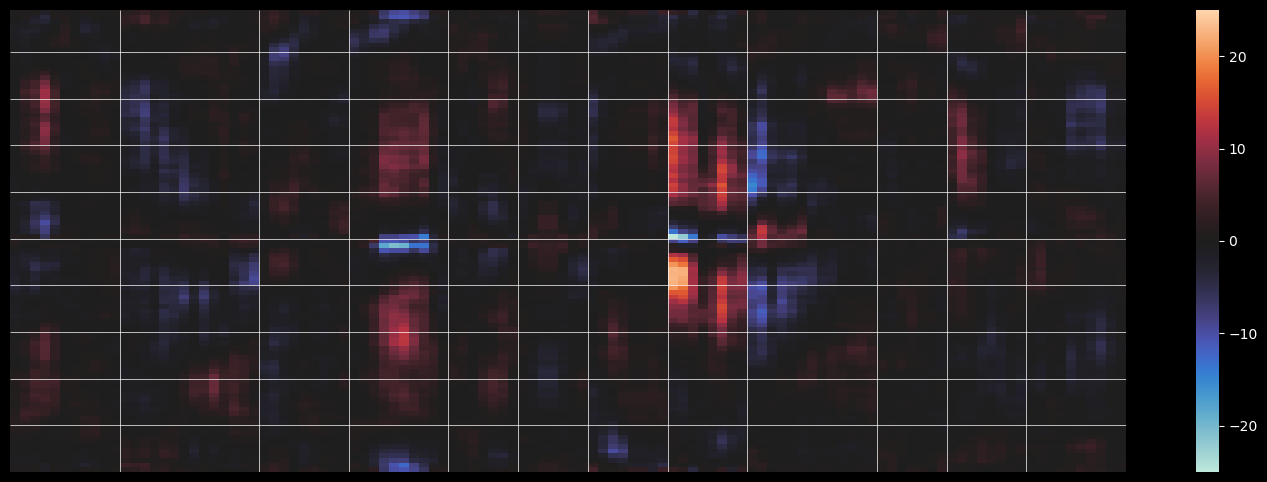

In [89]:
##########################################################
### VISUALIZE QTL FOR EACH PSEUDO-LANDMARK ACROSS BINS ###
##########################################################

# convert p vals to 1D array
left_pt_r_1D = np.reshape(left_pt_r, (np.shape(left_pt_r)[0]*np.shape(left_pt_r)[1]))

# calculate corrected p vals
corr_pvals = sm.multipletests(left_pt_r_1D, method="fdr_bh")[1]

# convert back to 2D array
corr_pvals_2D = np.reshape(corr_pvals, (np.shape(left_pt_r)[0],np.shape(left_pt_r)[1]))

# convert to -log10 p values
# change sign to that of the direction of distance from the mean
neglog10_pvals = -np.log10(corr_pvals_2D)*np.sign(left_pt_d)

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(neglog10_pvals, linewidths=0, ax=ax, cmap="icefire", vmin=-25, vmax=25)
ax.hlines([9,19,29,39,49,59,69,79,89], *ax.get_xlim(), color="white", lw=0.5)
ax.vlines([11,25,34,44,51,58,66,74,87,94,102,112], *ax.get_ylim(), color="white", lw=0.5)
plt.axis("off")

To visualize the genetic effect on shape continuously along the leaflet, we approximated the displacement contriubted by each significant quantitative trait locus (QTL) for each pseudo-landmark. For each QTL with a significant multiple test-adjusted p value, the p value (indicated by color), the displaced distance from the leaflet, and the respective point were stored. The directionality of the displacement from the mean contributed by each significant QTL was visualized as a normal vector inside or outside the mean shape. The start of the normal vector representing the displacement was calculated from the midpoint of neighboring pseudo-landmarks to the end point using the length of the displacement. Only significant displacements were visualized and a diverging color scheme was consistently used in the visualizations to indicate direction and the strength of the p-value.

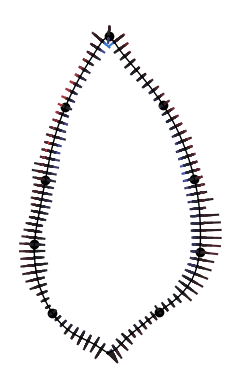

In [90]:
###################################################
### RETREIVE POINT INDICES, DISTANCES, AND PVALS###
###################################################

pts = [] # store the point indices
dists = [] # store the associated distances
pvals = [] # store the associated p values

for pt in range(np.shape(neglog10_pvals)[0]): # for each point
    
    for b in range(np.shape(neglog10_pvals)[1]): # for each bin
        
        curr_pval = neglog10_pvals[pt,b] # get the current p values
        
        if np.abs(curr_pval)>-np.log10(0.05): # only if the p value is <0.05

            pts.append(pt) # store the point identity
            dists.append(term_pt_d[pt,b]) # store the distance
            pvals.append(curr_pval) # store the p values

#################################################
### CALCULATE ENDPOINT OF NORMAL TO MEAN SHAPE###
#################################################

x0_vals = [] # store the mid point x vals
y0_vals = [] # store the mid point y vals
x3_vals = [] # store the end point x vals
y3_vals = [] # store the end point y vals
p_vals = [] # store the p vals

for i in range(len(pts)): # for all the points
    
    if pts[i]>=98: # because of indexing prev and next points, stop the point before
        continue

    D = dists[i] # find the current distance

    x1 = left_mean_shape[(pts[i])-1,0] # get the neighboring point xval before
    x2 = left_mean_shape[(pts[i])+1,0] # get the neighboring point xval after
    y1 = left_mean_shape[(pts[i])-1,1] # get the neighboring point yval before
    y2 = left_mean_shape[(pts[i])+1,1] # get the neighboring point yval after

    x3 = (x1+x2)/2+(( D/(np.sqrt((y1-y2)**2+(x2-x1)**2)))*(y1-y2)) # calculate the end x val point
    y3 = (y1+y2)/2+(( D/(np.sqrt((y1-y2)**2+(x2-x1)**2)))*(x2-x1)) # calculate the end y val point

    x0 = left_mean_shape[pts[i],0] # get the current x val
    y0 = left_mean_shape[pts[i],1] # get the current y val
    
    # store values
    x0_vals.append(x0)
    y0_vals.append(y0)
    x3_vals.append(x3)
    y3_vals.append(y3)
    p_vals.append(pvals[i])
    
#################################################
### VISUALIZE DISPLACEMENTS AROUND THE LEAFLET###
#################################################

cmap = plt.colormaps.get_cmap("icefire") # select color map
norm = Normalize(vmin=-25, vmax=25) # normalize
rgba_values = cmap(norm(p_vals)) # store cmap values for plotting

fig = plt.figure(facecolor="w")

for i in range(len(p_vals)):
    
    xvals = [-x0_vals[i], -x3_vals[i]]
    yvals = [y0_vals[i], y3_vals[i]]
    
    plt.plot(np.array(xvals), yvals, c=rgba_values[i])
    plt.gca().set_aspect("equal")
    plt.axis("off")

plt.plot(-left_mean_shape[:,0], 
         left_mean_shape[:,1], 
         c="k",lw=1)

plt.scatter(-left_mean_shape[[9,19,29,39,49,59,69,79,89],0], 
            left_mean_shape[[9,19,29,39,49,59,69,79,89],1], 
            c="k")

### Genetic analysis (right lateral leaflet)

***The analysis below is for the right lateral leaflet only.**

To dissect the genetic architecture underlying tomato leaflet shape to discrete locations in the leaflet, the distance of each pseudo-landmark to its respective mean was calculated. To do so, functions from the python module `shapely` provided directionality, by determining whether a point lies outside or inside the mean shape. Only ILs were used, as ultimately the correlation of the Eulcidean distance of each pseudo-landmark to the mean with the presence or absence of a specific introgression defining a bin was used to determine a genetic effect. 

In [91]:
####################################################################
### CALCULATE DISTANCES FROM MEAN FOR EACH POINT FOR EACH SAMPLE ###
####################################################################

# convert the mean shape into a shapely polygon object
shapely_polygon = Polygon(right_mean_shape)

# an array to store the Euclidean distance of each point of each leaflet to the mean leaflet
euclid_right_arr = np.zeros((
    len(right_df[right_df["IL"]!="m82"]), # the first dimension is the number of leaflets, not m82
    np.shape(proc_right_arr)[1] # the second dimension is the number of landmark points
))

right_ILs = [] # a list to store right leaflet IL identities

counter = 0

for lf in range(np.shape(proc_right_arr)[0]): # for each leaflet "lf"
    
    if right_df["IL"].iloc[lf]=="m82": # if the current leaflet is m82, continue
        continue
        
    else: # else, proceed with the IL leaflet
        right_ILs.append(right_df["IL"].iloc[lf])
    
    for pt in range(np.shape(proc_right_arr)[1]): # then, for that leaflet, for each point "pt"
        
        x1 = right_mean_shape[pt,0] # x1 is the x value of point pt for the mean shape
        y1 = right_mean_shape[pt,1] # y1 is the y value of point pt for the mean shape
        
        x2 = proc_right_arr[lf,pt,0] # x2 is the x value of leaflet lf of point pt 
        y2 = proc_right_arr[lf,pt,1] # y2 is the y value of leaflet lf of point pt 
        
        shapely_point = Point(x2, y2) # convert point to Shapely point object
        
        d = euclid_dist(x1, y1, x2, y2) # calculate the Euclidean distance d
        
        if shapely_polygon.contains(shapely_point): # if the mean shape contains the point
            d = -d # then the point is inside the mean shape and it should be negative
        else:
            d = d # else the point is outside the mean shape and it should remain positive
        
        euclid_right_arr[counter,pt] = d # store the distance value in the lf, pt position of the euclid_arr
        
    counter+=1

# take a look at the shape/dimensions of the final array
print(np.shape(euclid_right_arr))

(3609, 99)


Using dataframes, the presence or absence of each bin (encoded in binary `1` or `0`) for each IL line was merged with the IL identity of the leaflets analyzed. Spearman's rank correlation was used to correlate bin presence or absence with directional Euclidean distance. Both the p-value associated with Spearan's rho and the distance of the pseudo-landmark to the mean were stored for visualization and further analysis.

In [92]:
###################################################
### CALCULATE PVALS FOR EACH POINT FOR EACH BIN ###
###################################################

IL_bin_df = plant_IL_bin.iloc[:,1:].drop_duplicates() # drop duplicate values of IL_bin_df
IL_bin_df.rename(columns={'genotype':'IL'}, inplace=True) # rename genotype to IL for merging
right_IL_df = pd.DataFrame({"IL":right_ILs}) # convert right_IL list to df and name column IL for merging
right_IL_bin = right_IL_df.merge(IL_bin_df, "left") # merge the right leaflet IL identities to bins

# an array to store the spearman r p vals for each point, for each bin
right_pt_r = np.zeros((
    np.shape(euclid_right_arr)[1], # number of points
    len(right_IL_bin.iloc[:,1:].columns) # number of bins
))

# an array to store the average distances from mean for each point, for each bin
right_pt_d = np.zeros((
    np.shape(euclid_right_arr)[1], # number of points
    len(right_IL_bin.iloc[:,1:].columns) # number of bins
))

for pt in range(np.shape(euclid_right_arr)[1]): # for each point
    
    if pt%10==0: # print every 10th point
        print(pt)
    
    curr_pt = euclid_right_arr[:,pt] # get distances for current point

    for b in range(len(right_IL_bin.iloc[:,1:].columns)): # for each bin
                   
        curr_bins = np.array(right_IL_bin.iloc[:,b+1]) # get the current bin presence values
        mean_dist = np.mean(curr_pt[np.where(curr_bins==1)]) # average euclid dist of points harboring current bin
        right_pt_d[pt,b] = mean_dist # store mean distances of points with current bin identity
        res = stats.spearmanr(curr_pt, curr_bins) # calculate spearman correlation
        right_pt_r[pt,b] = res[1] # store spearman r value to array
                    

0
10
20
30
40
50
60
70
80
90


Resulting p values were multiple test adjusted using the Benjamini-Hochberg (BH) false discovery rate-controlling procedure, their sign converted to the direction of the deviation of the pseudo-landmark from the mean (negative for inside the mean contour and positive for outside), and visualized as negative log-base 10 values. The plot of pseudo-landmark position along the leaflet vs. bin position along the genome shows the dynamic genetic architecture across the leaflet blade continuously.

(0.0, 112.0, 99.0, 0.0)

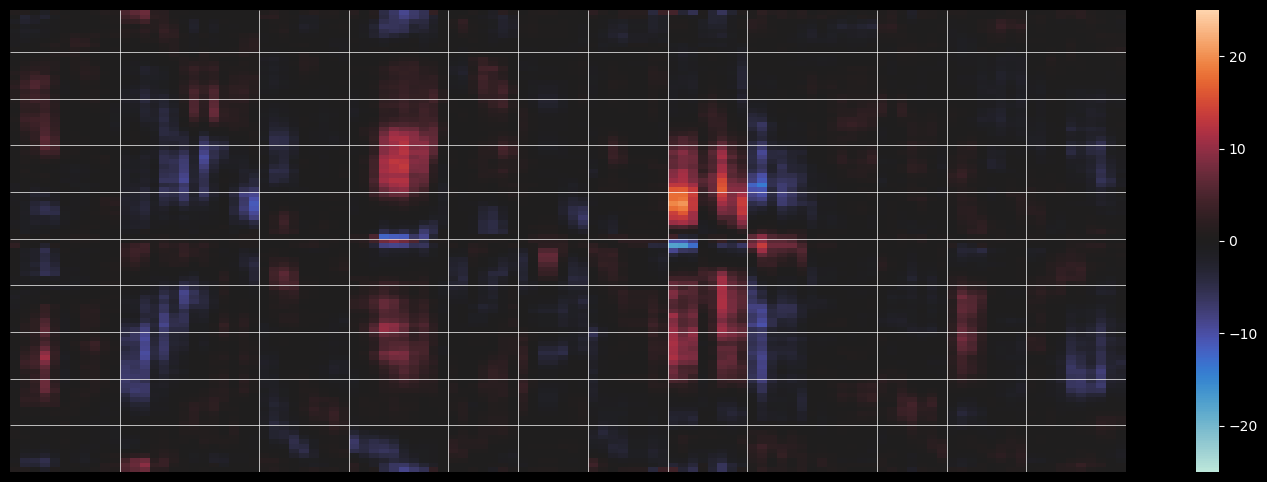

In [93]:
##########################################################
### VISUALIZE QTL FOR EACH PSEUDO-LANDMARK ACROSS BINS ###
##########################################################

# convert p vals to 1D array
right_pt_r_1D = np.reshape(right_pt_r, (np.shape(right_pt_r)[0]*np.shape(right_pt_r)[1]))

# calculate corrected p vals
corr_pvals = sm.multipletests(right_pt_r_1D, method="fdr_bh")[1]

# convert back to 2D array
corr_pvals_2D = np.reshape(corr_pvals, (np.shape(right_pt_r)[0],np.shape(right_pt_r)[1]))

# convert to -log10 p values
# change sign to that of the direction of distance from the mean
neglog10_pvals = -np.log10(corr_pvals_2D)*np.sign(right_pt_d)

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(neglog10_pvals, linewidths=0, ax=ax, cmap="icefire", vmin=-25, vmax=25)
ax.hlines([9,19,29,39,49,59,69,79,89], *ax.get_xlim(), color="white", lw=0.5)
ax.vlines([11,25,34,44,51,58,66,74,87,94,102,112], *ax.get_ylim(), color="white", lw=0.5)
plt.axis("off")

To visualize the genetic effect on shape continuously along the leaflet, we approximated the displacement contriubted by each significant quantitative trait locus (QTL) for each pseudo-landmark. For each QTL with a significant multiple test-adjusted p value, the p value (indicated by color), the displaced distance from the leaflet, and the respective point were stored. The directionality of the displacement from the mean contributed by each significant QTL was visualized as a normal vector inside or outside the mean shape. The start of the normal vector representing the displacement was calculated from the midpoint of neighboring pseudo-landmarks to the end point using the length of the displacement. Only significant displacements were visualized and a diverging color scheme was consistently used in the visualizations to indicate direction and the strength of the p-value.

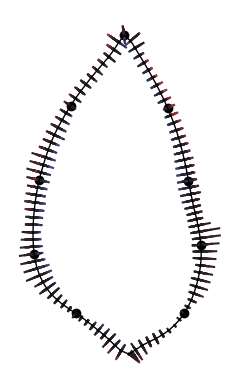

In [94]:
###################################################
### RETREIVE POINT INDICES, DISTANCES, AND PVALS###
###################################################

pts = [] # store the point indices
dists = [] # store the associated distances
pvals = [] # store the associated p values

for pt in range(np.shape(neglog10_pvals)[0]): # for each point
    
    for b in range(np.shape(neglog10_pvals)[1]): # for each bin
        
        curr_pval = neglog10_pvals[pt,b] # get the current p values
        
        if np.abs(curr_pval)>-np.log10(0.05): # only if the p value is <0.05

            pts.append(pt) # store the point identity
            dists.append(term_pt_d[pt,b]) # store the distance
            pvals.append(curr_pval) # store the p values

#################################################
### CALCULATE ENDPOINT OF NORMAL TO MEAN SHAPE###
#################################################

x0_vals = [] # store the mid point x vals
y0_vals = [] # store the mid point y vals
x3_vals = [] # store the end point x vals
y3_vals = [] # store the end point y vals
p_vals = [] # store the p vals

for i in range(len(pts)): # for all the points
    
    if pts[i]>=98: # because of indexing prev and next points, stop the point before
        continue

    D = dists[i] # find the current distance

    x1 = right_mean_shape[(pts[i])-1,0] # get the neighboring point xval before
    x2 = right_mean_shape[(pts[i])+1,0] # get the neighboring point xval after
    y1 = right_mean_shape[(pts[i])-1,1] # get the neighboring point yval before
    y2 = right_mean_shape[(pts[i])+1,1] # get the neighboring point yval after

    x3 = (x1+x2)/2-(( D/(np.sqrt((y1-y2)**2+(x2-x1)**2)))*(y1-y2)) # calculate the end x val point
    y3 = (y1+y2)/2-(( D/(np.sqrt((y1-y2)**2+(x2-x1)**2)))*(x2-x1)) # calculate the end y val point

    x0 = right_mean_shape[pts[i],0] # get the current x val
    y0 = right_mean_shape[pts[i],1] # get the current y val
    
    # store values
    x0_vals.append(x0)
    y0_vals.append(y0)
    x3_vals.append(x3)
    y3_vals.append(y3)
    p_vals.append(pvals[i])
    
#################################################
### VISUALIZE DISPLACEMENTS AROUND THE LEAFLET###
#################################################

cmap = plt.colormaps.get_cmap("icefire") # select color map
norm = Normalize(vmin=-25, vmax=25) # normalize
rgba_values = cmap(norm(p_vals)) # store cmap values for plotting

fig = plt.figure(facecolor="w")

for i in range(len(p_vals)):
    
    xvals = [x0_vals[i], x3_vals[i]]
    yvals = [y0_vals[i], y3_vals[i]]
    
    plt.plot(xvals, yvals, c=rgba_values[i])
    plt.gca().set_aspect("equal")
    plt.axis("off")

plt.plot(right_mean_shape[:,0], 
         right_mean_shape[:,1], 
         c="k",lw=1)

plt.scatter(right_mean_shape[[9,19,29,39,49,59,69,79,89],0], 
            right_mean_shape[[9,19,29,39,49,59,69,79,89],1], 
            c="k")